In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

In [2]:
script_fname = '/Users/benjamin/Desktop/DSI/capstone/the-simpsons-by-the-data/simpsons_script_lines.csv'

# import errors for imconsistent use of quotations removed by `error_bad_lines` call
script_df = pd.read_csv(script_fname, error_bad_lines = False)
# many of the NaNs of this dataframe are unable to be completer (location, character, timestamp) and should be dropped
script_df.dropna(axis=0, inplace=True)
# keep only the normalized lines so capitalization isn't a problem
script_df.drop('normalized_text', axis=1, inplace=True)
# remove the uncleaned, raw script lines along with duplicate columns
script_df.drop('raw_text', axis=1, inplace=True)
script_df.drop('timestamp_in_ms', axis=1, inplace=True)
script_df.drop('location_id', axis=1, inplace=True)
script_df.drop('character_id', axis=1, inplace=True)
# using speaking lines only
script_df = script_df[script_df['speaking_line'] == True]
script_df.head()

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

,id,episode_id,number,speaking_line,raw_character_text,raw_location_text,spoken_words,word_count
0,9549,32,209,True,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",31.0
1,9550,32,210,True,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,3.0
2,9551,32,211,True,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,22.0
3,9552,32,212,True,Lisa Simpson,Springfield Elementary School,That life is worth living.,5.0
4,9553,32,213,True,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,33.0


In [3]:
script_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108676 entries, 0 to 131070
Data columns (total 8 columns):
id                    108676 non-null int64
episode_id            108676 non-null int64
number                108676 non-null int64
speaking_line         108676 non-null object
raw_character_text    108676 non-null object
raw_location_text     108676 non-null object
spoken_words          108676 non-null object
word_count            108676 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 7.5+ MB


For this analysis I chose to only work with the spoken lines in the corpus, to avoid the nuance of scene notes.

I tried to fix the `word_count` column by using a `.apply(lambda x: len(x))` for the column, but found several of the lines were missing the script lines, so I decided to drop amy lines with NaNs for the initial analysis, although I could come back to this after building the models how I'd like them to be.

In [4]:
script_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108676 entries, 0 to 131070
Data columns (total 8 columns):
id                    108676 non-null int64
episode_id            108676 non-null int64
number                108676 non-null int64
speaking_line         108676 non-null object
raw_character_text    108676 non-null object
raw_location_text     108676 non-null object
spoken_words          108676 non-null object
word_count            108676 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 7.5+ MB


In [5]:
# the description of the quantifiable areas shows that there are some monologues (over 100 words) and some one-lines ("d'oh!")
script_df.describe()

,id,episode_id,number,word_count
count,108676.000000,108676.000000,108676.000000,108676.000000
mean,74906.584609,262.348219,142.633001,9.860098
std,37974.091369,135.026827,83.594053,7.941941
min,9549.000000,32.000000,1.000000,1.000000
25%,42336.500000,148.000000,71.000000,4.000000
50%,74480.500000,259.000000,141.000000,8.000000
75%,107647.250000,376.000000,211.000000,13.000000
max,141734.000000,506.000000,394.000000,122.000000


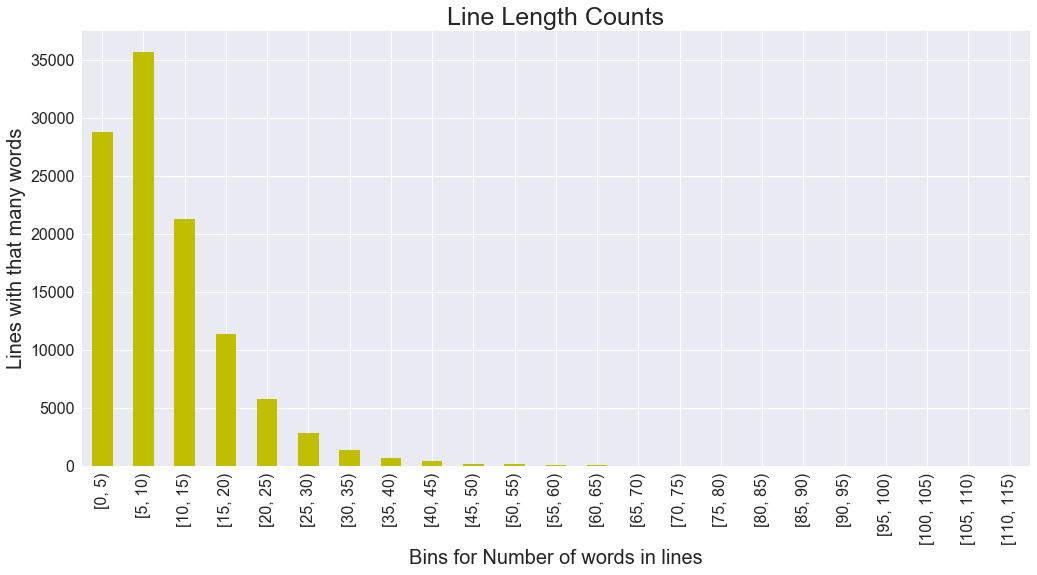

In [6]:
# the distribution of length of lines
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111)
step = 5
bin_range = np.arange(0, 120, step)
out, bins  = pd.cut(script_df['word_count'], bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False).plot.bar(color='y')
plt.title('Line Length Counts', size=25)
plt.tick_params(labelsize=16)
plt.xlabel('Bins for Number of words in lines', size=20)
plt.ylabel('Lines with that many words', size=20)


Notice there are very very few long lines from the script. We should dig into this more. 

In [7]:
plt.close('all')
print('average words per line :', round(script_df['word_count'].mean(), 2))
print('\n')
print('first episode featured: ', script_df.episode_id.min(), '     last episode featured: ', script_df.episode_id.max())
print('\n')
print('lines with more than 100 words: ', script_df[script_df.word_count >= 100].speaking_line.count())
print('\n')
print('characters with more than 100 lines > AKA "Who\'s speaking for that long?"')
print(script_df[script_df.word_count >= 100][['raw_character_text', 'episode_id']])

average words per line : 9.86


first episode featured:  32      last episode featured:  506


lines with more than 100 words:  9


characters with more than 100 lines > AKA "Who's speaking for that long?"
       raw_character_text  episode_id
6319              Singers          52
13084      Grampa Simpson          76
18231         James Woods          94
18747       Kent Brockman          96
42166       Homer Simpson         184
69514         Moe Szyslak         274
89997     David Silverman         347
123992       Randy Newman         478
125143    Ewell Freestone         482


Only 9 episodes have what should be considered 'monologues'
HOWEVER
It looks like there is at least one song in the mix ('singers' listed as character) and only one major character has a monologue (Homer in episode `184`), unless you consider Grampa Simpson a major character, which....  some people may.

In [8]:
# getting episode info for lines spoke by episode

sorted_df = script_df.groupby('episode_id').count()
sorted_df.head()

,id,number,speaking_line,raw_character_text,raw_location_text,spoken_words,word_count
episode_id,,,,,,,
32,100,100,100,100,100,100,100
33,291,291,291,291,291,291,291
34,315,315,315,315,315,315,315
35,272,272,272,272,272,272,272
36,275,275,275,275,275,275,275


let's plot that

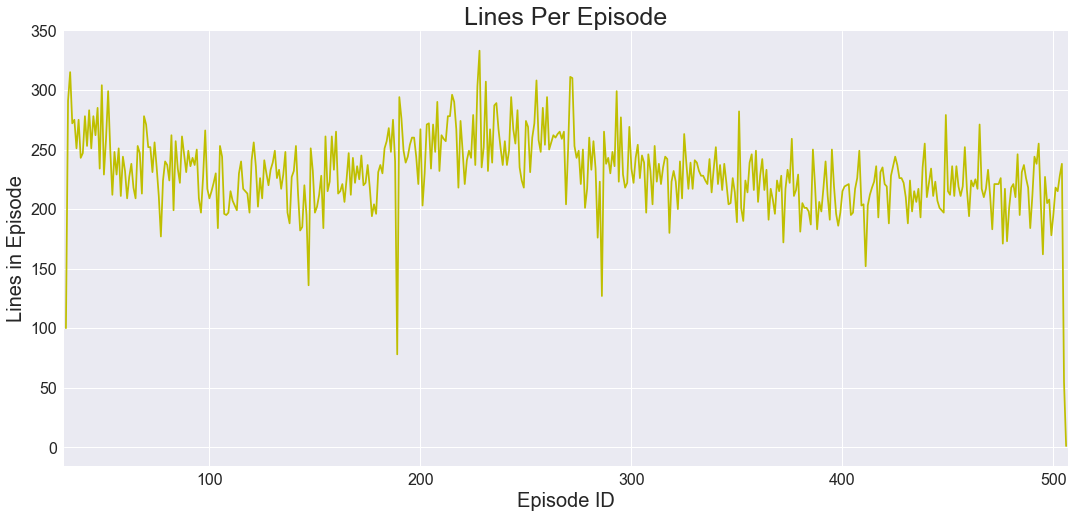

In [9]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
ax.plot(sorted_df.speaking_line, color='y')
ax.set_title('Lines Per Episode', size=25)
ax.tick_params(labelsize=16)
ax.set_xlabel('Episode ID', size=20)
ax.set_ylabel('Lines in Episode', size=20)
ax.set_xlim((31, 507))
plt.show()

I wonder what's up with the super short episodes (`lines <= 100`), especially with the last episode featured (maybe it was one with a lot of `NaNs`?)